In [1]:
import os
import numpy as np

from pcntoolkit.util.utils import calibration_descriptives
from pcntoolkit.dataio.fileio import load_nifti, save_nifti
from pcntoolkit.dataio.fileio import load as ptkload
from pcntoolkit.dataio.fileio import save as ptksave

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from pathlib  import Path
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

# globals
root_dir = '/project_cephfs/3022017.06/ENIGMA_ANX/'

###  CHANGE DEPENDING ON Z-STAT OR SCALED EFFECT  ###
proc_dir = os.path.join(root_dir,'Z_stat/')
#proc_dir = os.path.join(root_dir,'Scaled_effect/')

data_dir = os.path.join(proc_dir,'data/')
w_dir = os.path.join(proc_dir,'vox/')
mask_nii = ('/opt/fmriprep/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz')
ex_nii = os.path.join(data_dir, 'ENIGMA_FC_tr_1.nii.gz')
output_suffix = '_predcl'
batch_size = 400 


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load data
y_te = ptkload(os.path.join(proc_dir,'resp_cl.pkl'))
EV = ptkload(os.path.join(w_dir,'EXPV_predcl.pkl')) 
Z = ptkload(os.path.join(w_dir,'Z_predcl.pkl'))
SMSE = ptkload(os.path.join(w_dir,'SMSE_predcl.pkl'))

Z[np.isnan(Z)] = 0
Z[np.isinf(Z)] = 0

[skew, sds, kurtosis, sdk, semean, sesd] = calibration_descriptives(Z)

badk = np.abs(kurtosis) > 10
kurtosis2 = kurtosis[~badk]

bads = np.abs(skew) > 10
skew2 = skew[~bads]

# fix some random bad voxels 
EV[EV < -1] = 0


In [4]:
#Save output nii.gz files
ptksave(skew, os.path.join(w_dir,'skew' + output_suffix + '.nii.gz'), example=ex_nii, mask=mask_nii)
ptksave(kurtosis, os.path.join(w_dir,'kurtosis' + output_suffix + '.nii.gz'), example=ex_nii, mask=mask_nii)
ptksave(SMSE.T, os.path.join(w_dir,'SMSE' + output_suffix + '.nii.gz'), example=ex_nii, mask=mask_nii)
ptksave(EV.T, os.path.join(w_dir,'EV' + output_suffix + '.nii.gz'), example=ex_nii, mask=mask_nii)
ptksave(Z, os.path.join(w_dir,'Z' + output_suffix + '.nii.gz'), example=ex_nii, mask=mask_nii)
ptksave(y_te, os.path.join(w_dir,'y' + output_suffix + '.nii.gz'), example=ex_nii, mask=mask_nii)
ptksave(np.arange(len(EV)), os.path.join(w_dir,'idx.nii.gz'), example=ex_nii, mask=mask_nii, dtype='uint32')

# load the index again in volumetric form
idxvol = ptkload(os.path.join(w_dir,'idx.nii.gz'), mask=mask_nii, vol=True)

# find the voxel coordinates for a given value
#vox_id = np.where(badk)[0][0]
#vox_coord = np.asarray(np.where(idxvol == vox_id)).T

# alternative method (opposite direction)
vox_coord = (11,13,60)
vox_id = int(idxvol[vox_coord])

# find batch id
#batch_num, mod_num = divmod(vox_id, batch_size)
#batch_num = batch_num + 1 # batch indexing starts at 1

Make plots of the evaluation metrics

In [2]:
#Load in files
EV = load_nifti(os.path.join(w_dir,'EV_predcl.nii.gz'))
Kurtosis = load_nifti(os.path.join(w_dir,'kurtosis_predcl.nii.gz'))
Skew = load_nifti(os.path.join(w_dir,'skew_predcl.nii.gz'))
SMSE =load_nifti(os.path.join(w_dir,'SMSE_predcl.nii.gz'))

save_loc = os.path.join(proc_dir,'plots')

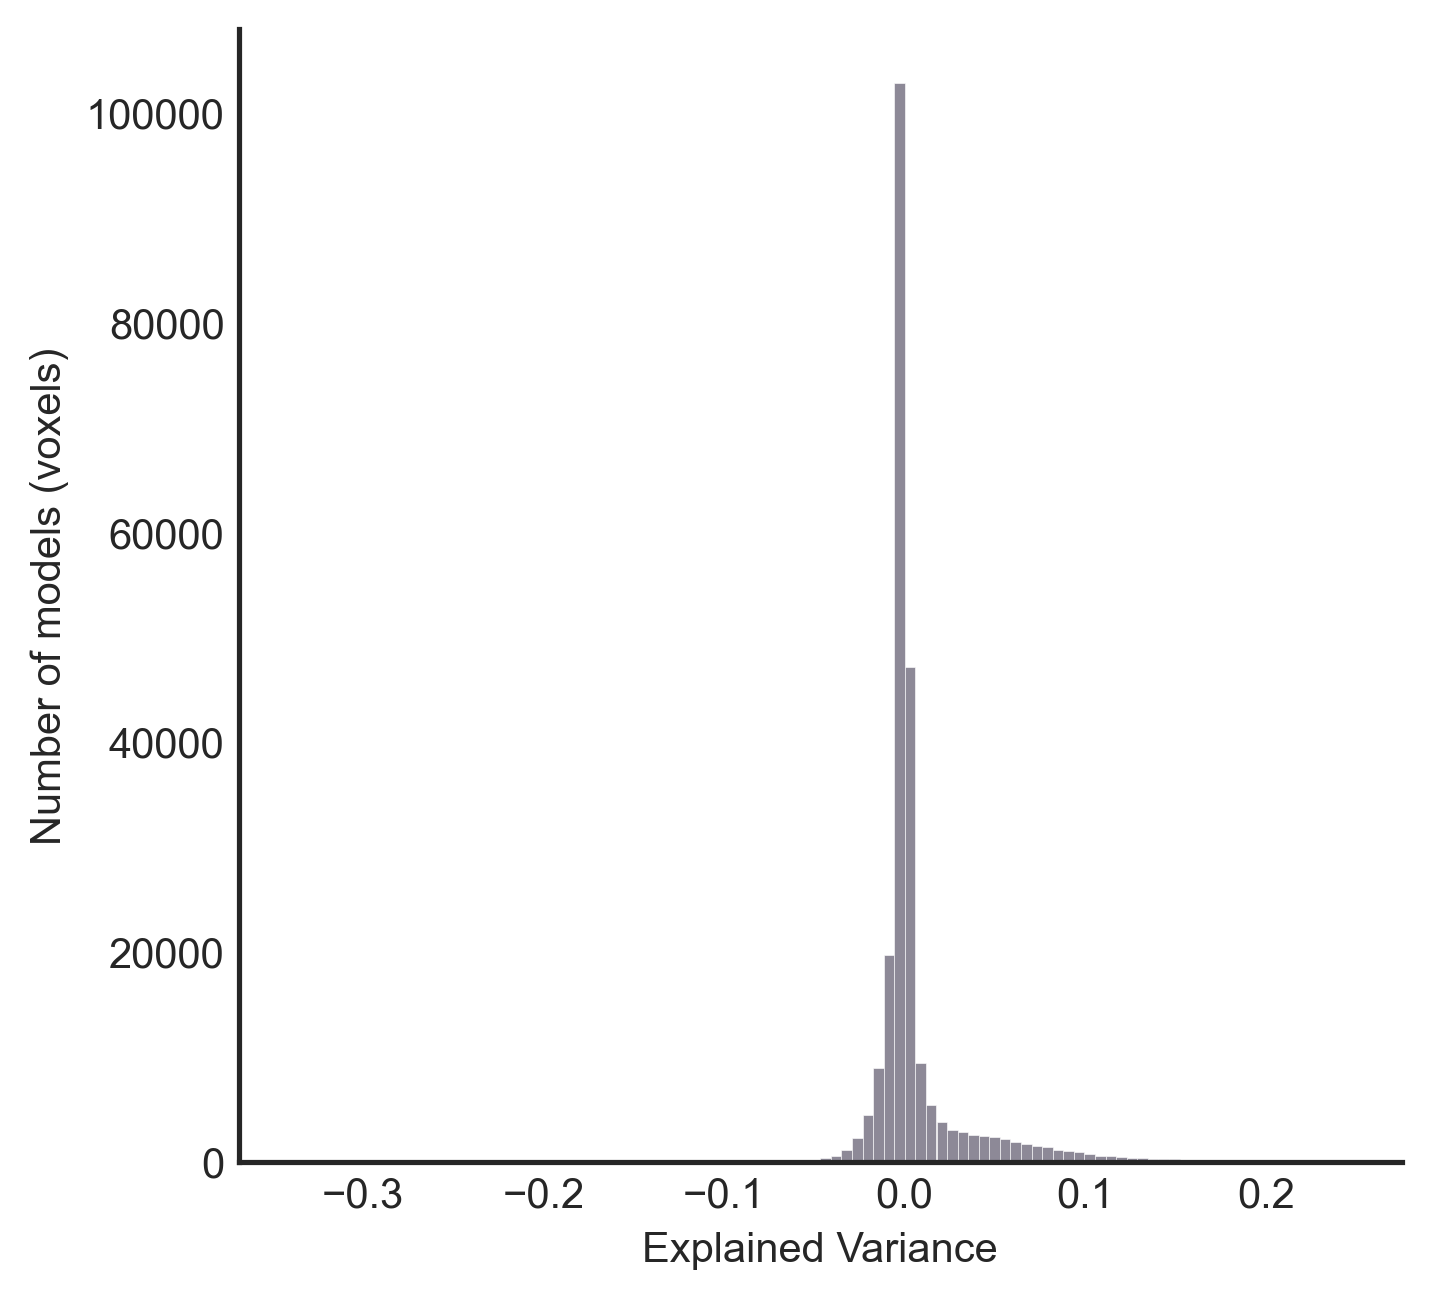

In [3]:
#FIG 1A: EV histogram
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()

max_x = (max(EV)+0.005)

ax.hist(EV, bins = 100, ec = 'white', lw=0.2, fc = '#5D576B', alpha = 0.7) 
plt.xlabel('Explained Variance', font = fpath)
plt.ylabel('Number of models (voxels)', font = fpath)
#plt.axis([min(EV),max_x, 0, 60000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(font = fpath)
plt.yticks(font = fpath)

plt.show()
fig.savefig(os.path.join(save_loc +'/EV_histogram_cl.png'), dpi=300)

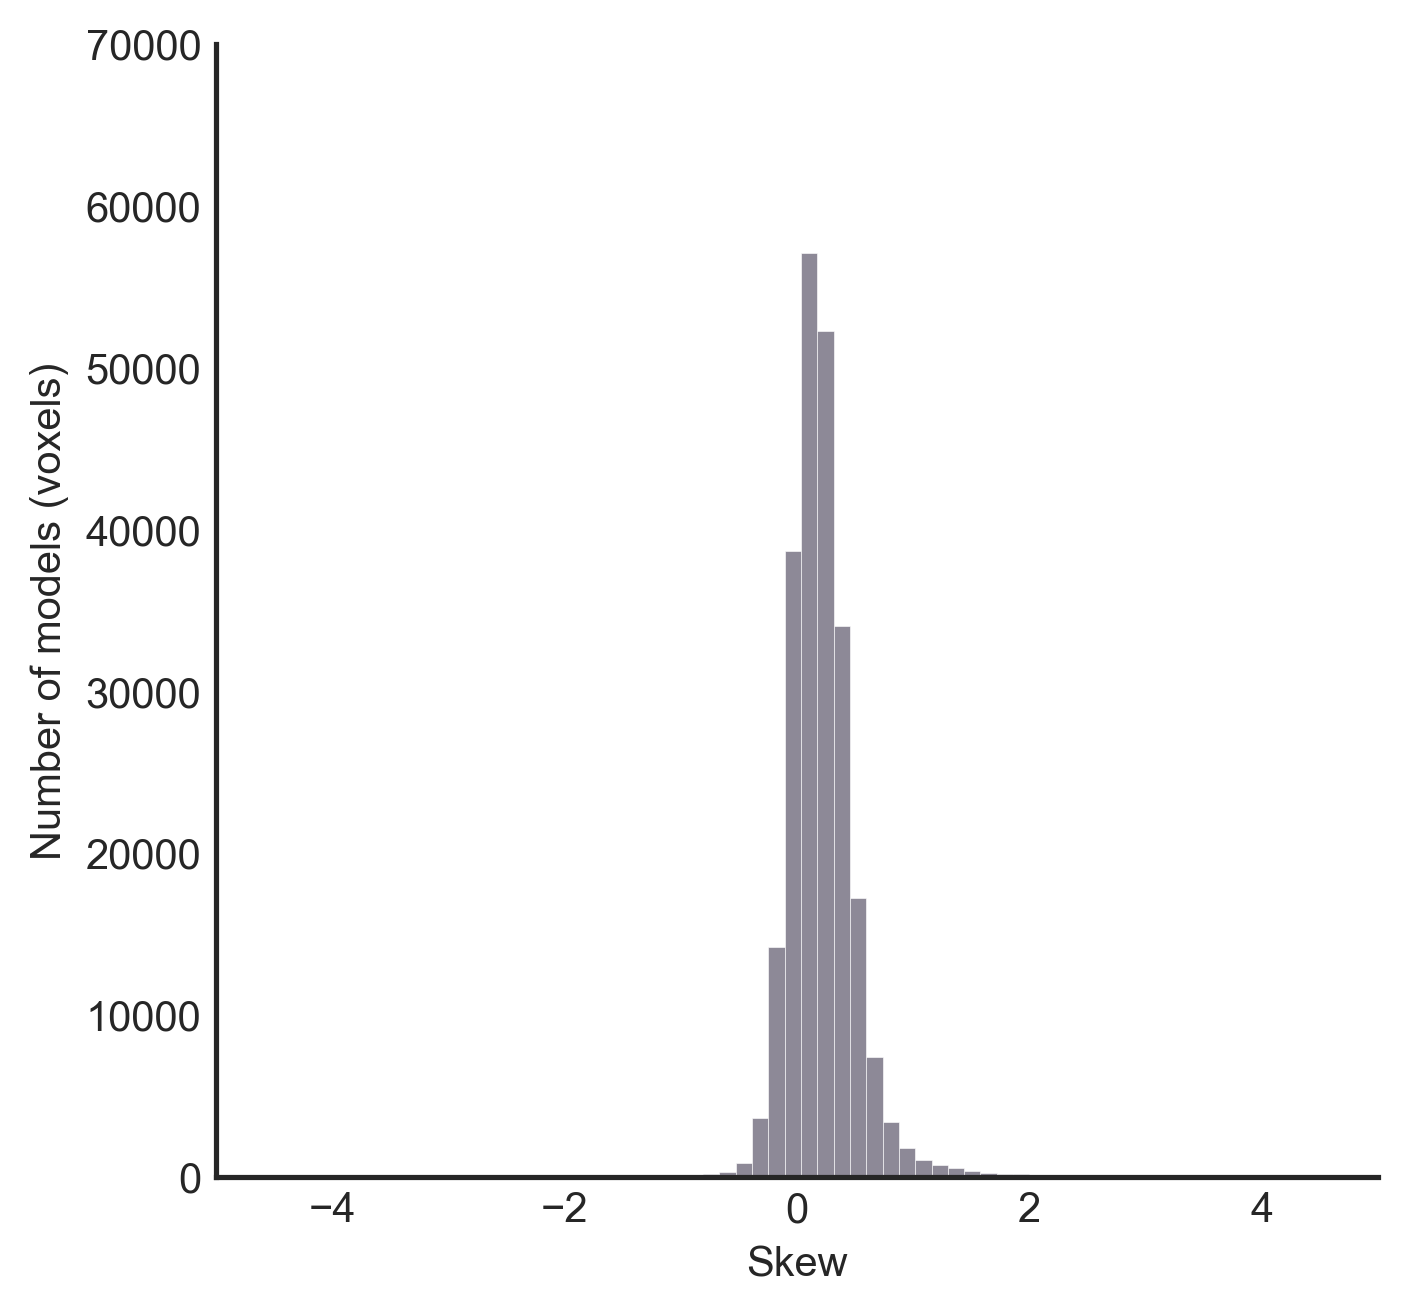

In [4]:
#FIG 1B: Skew histogram
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()

max_x = (max(Skew)+0.005)
min_x = (min(Skew)-0.005)

ax.hist(Skew, bins = 200, ec = 'white', lw=0.2, fc = '#5D576B', alpha = 0.7) 
plt.xlabel('Skew', font = fpath)
plt.ylabel('Number of models (voxels)', font = fpath)
#plt.axis([min_x,max_x, 0, 25000])
#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axis([-5,5, 0, 70000])
plt.xticks(font = fpath)
plt.yticks(font = fpath)

plt.show()
fig.savefig(os.path.join(save_loc +'/Skew_histogram_cl.png'), dpi=300)

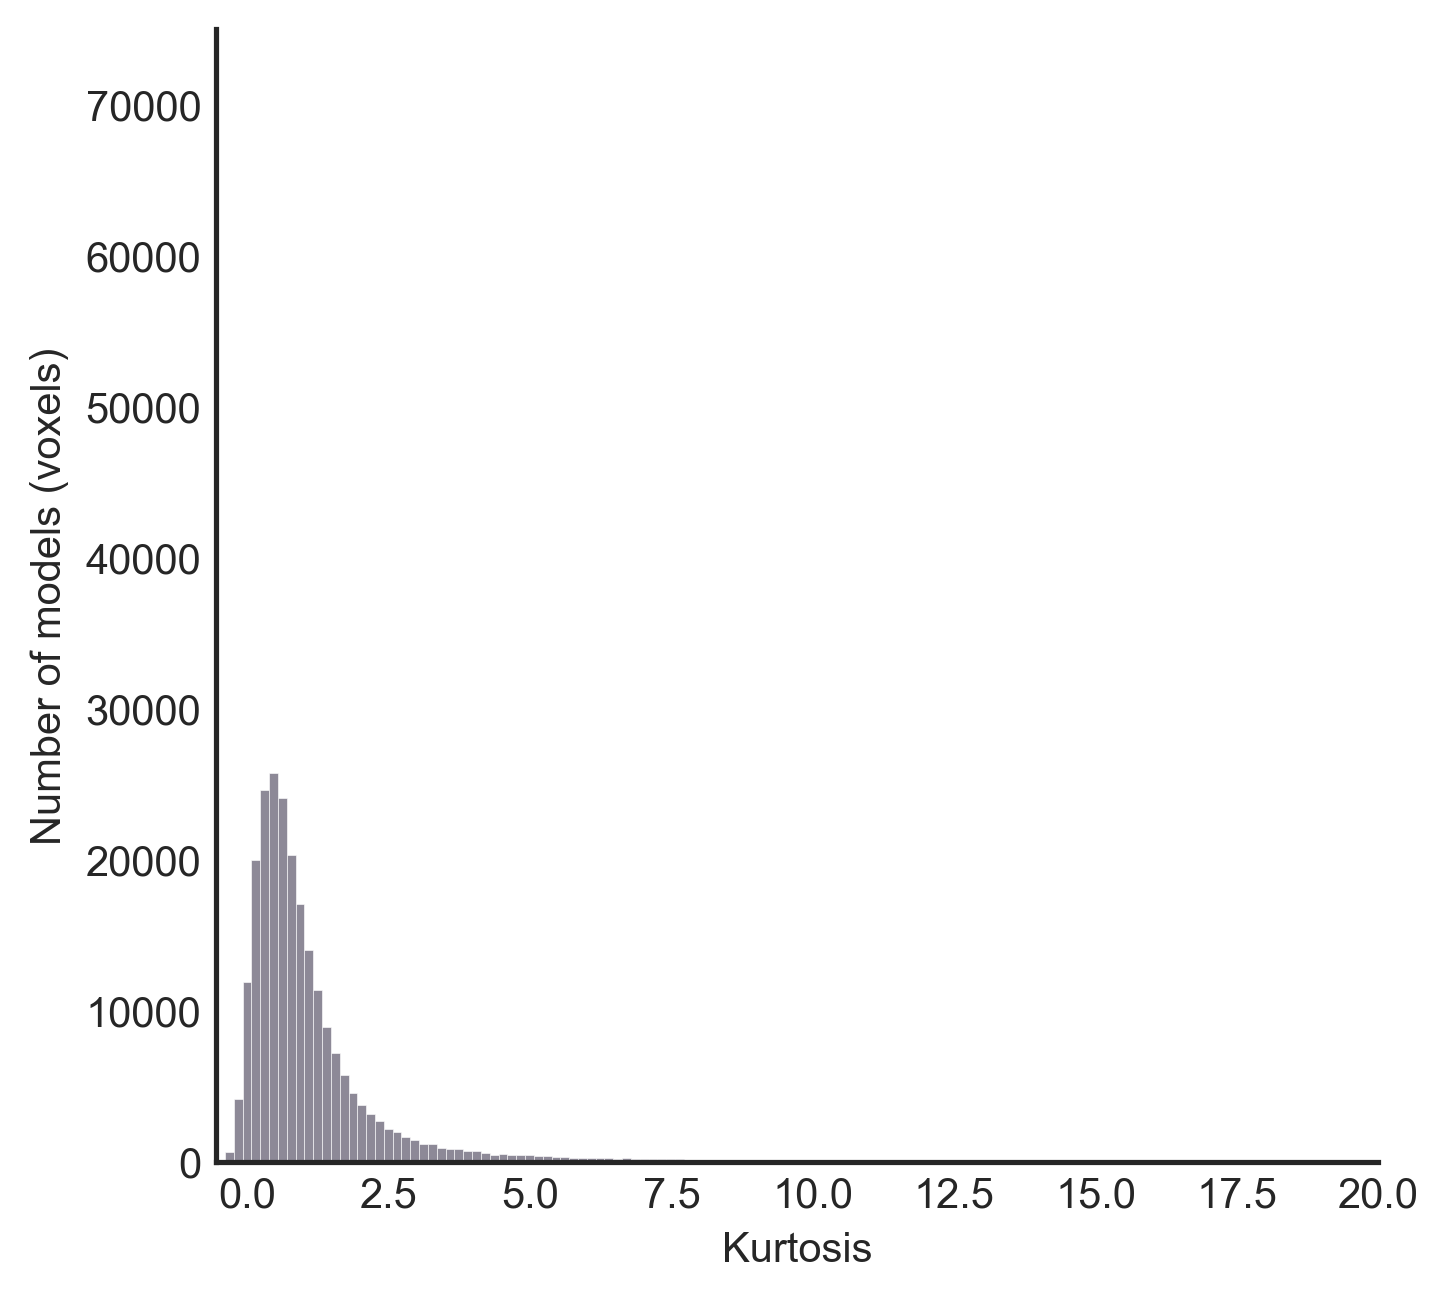

In [5]:
#FIG 1C: Kurtosis histogram
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()

min_x = (min(Kurtosis)-0.005)

ax.hist(Kurtosis, bins = 2000, ec = 'white', lw=0.2, fc = '#5D576B', alpha = 0.7) 
plt.xlabel('Kurtosis',font = fpath)
plt.ylabel('Number of models (voxels)', font = fpath)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axis([min_x,20, 0, 75000])
plt.xticks(font = fpath)
plt.yticks(font = fpath)

plt.show()
fig.savefig(os.path.join(save_loc +'/Kurtosis_histogram_cl.png'), dpi=300)

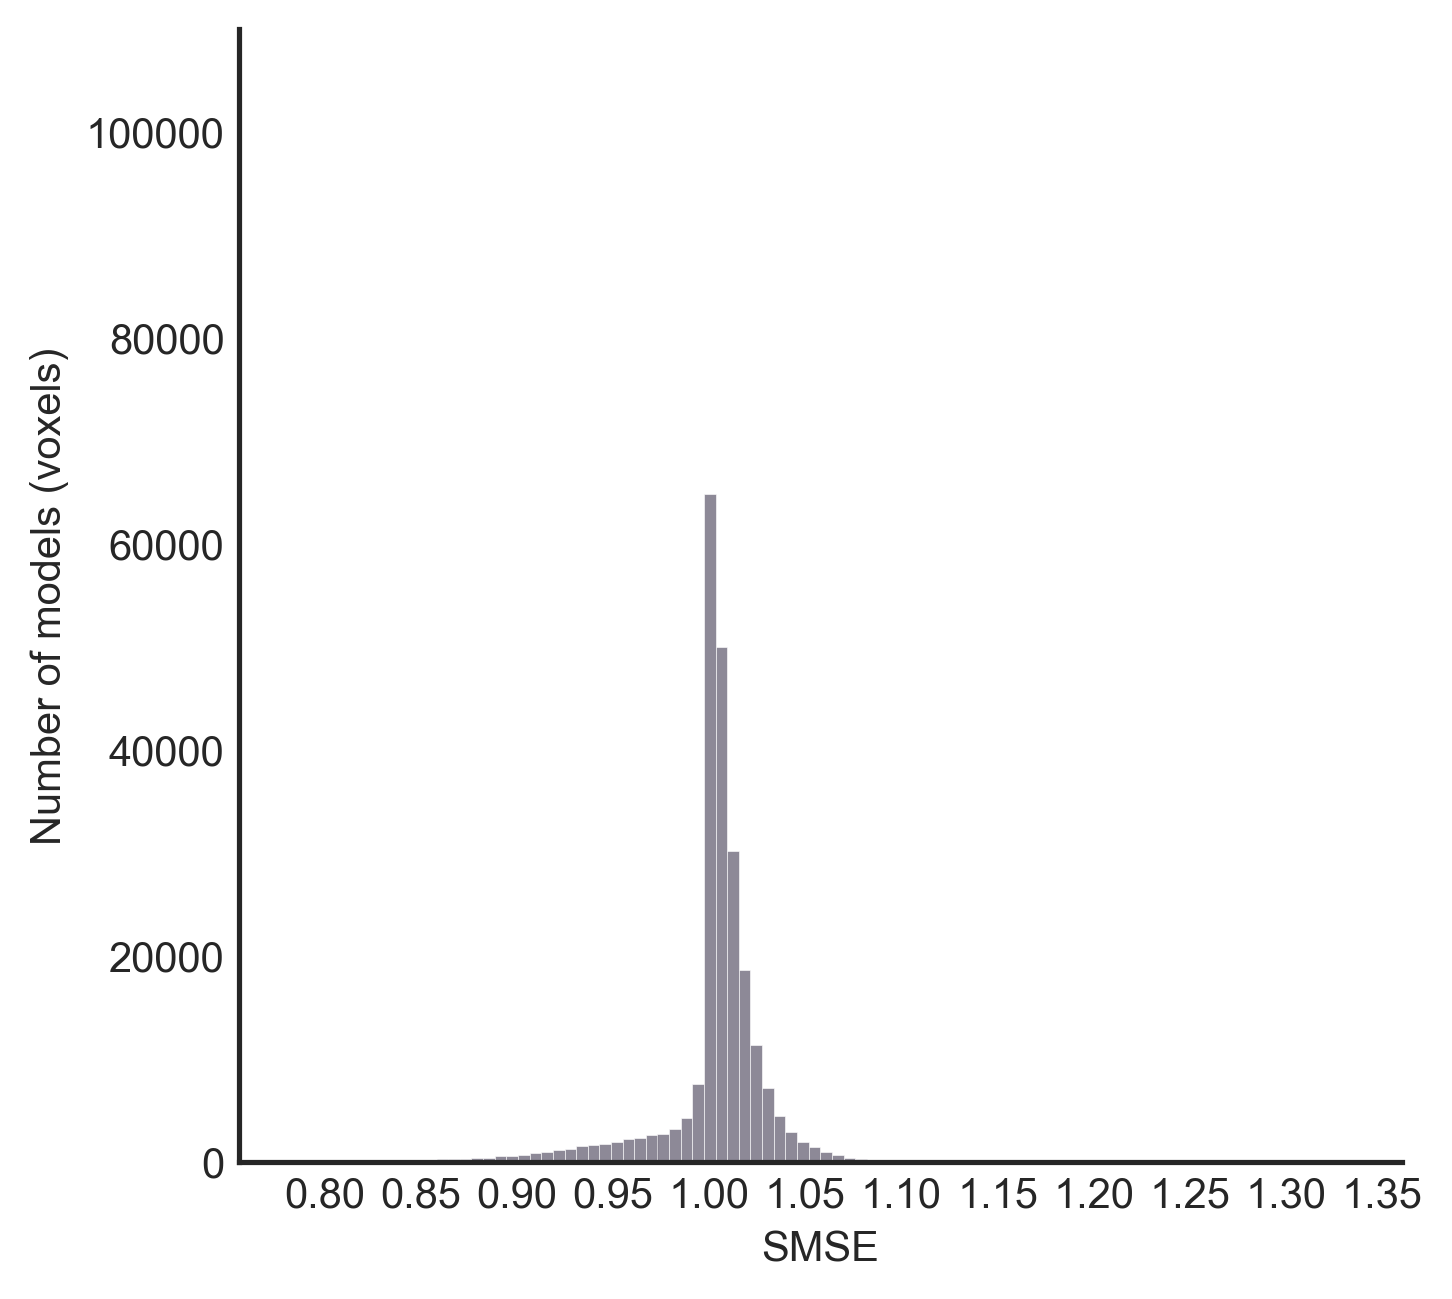

In [6]:
#FIG 1D: SMSE histogram
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()

max_x = (max(SMSE)+0.005)

ax.hist(SMSE, bins = 100, ec = 'white', lw=0.2, fc = '#5D576B', alpha = 0.7) 
plt.xlabel('SMSE', font = fpath)
plt.ylabel('Number of models (voxels)',font = fpath)
plt.axis([min(SMSE),max(SMSE), 0, 110000])
#ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(font = fpath)
plt.yticks(font = fpath)

plt.show()
fig.savefig(os.path.join(save_loc +'/SMSE_histogram_cl.png'), dpi=300)